##🚀drive mounting

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1gnEmwyGy0LbTbJbAObG1GluWXj6wpHMD/[2024-2025] AN2DL/Homework 2


##📚importing libraries

In [ ]:
# Set seed for reproducibility
seed = 42


# Import necessary libraries

import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
import numpy as np

data = np.load("filtered_mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
import gc
del data, training_set
gc.collect()

26

###visual inspection

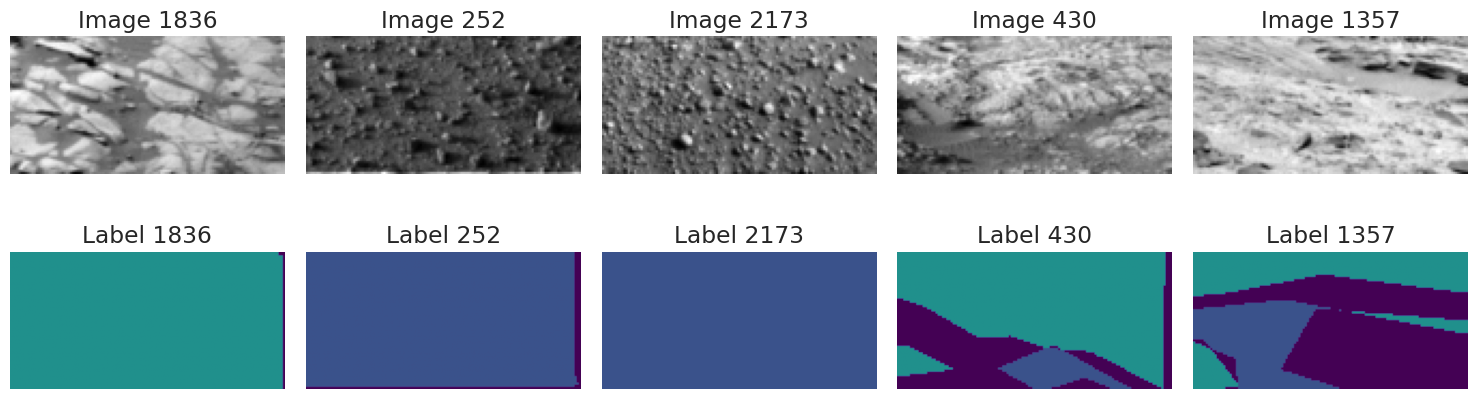

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot random images with labels
def plot_random_images_with_labels(images, labels, num=5):
    """
    Plot `num` random images with their corresponding label masks.

    Parameters:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of label masks.
        num (int): Number of images to plot.
    """
    # Select `num` random indices
    random_indices = np.random.choice(len(images), num, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(random_indices):
        # Display the image
        plt.subplot(2, num, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Display the mask with viridis
        plt.subplot(2, num, i + 1 + num)
        plt.imshow(labels[idx], cmap='viridis', vmin=0, vmax=4)
        plt.title(f"Label {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot 5 random images with labels
plot_random_images_with_labels(X_train, y_train, num=5)


###data processing

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Distribuzione delle classi: {0.0: 4988826, 1.0: 6957538, 2.0: 4776810, 3.0: 3770823, 4.0: 26963}


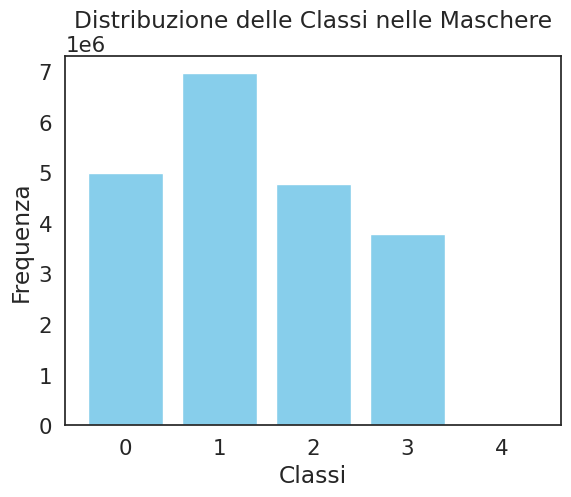

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Class distribution:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution in Masks')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Number of unique classes in the dataset: {len(class_distribution)}")


In [ ]:
from sklearn.model_selection import train_test_split

# First split: division into train and temp (which will become validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Second split: division into validation and test
X_val, X_test_tmp, y_val, y_test_tmp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the size of the new splits
print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test_tmp)}")


Number of images:
Train: 2004
Validation: 250
Test: 251


Distribuzione delle classi: {0.0: 3979893, 1.0: 5532162, 2.0: 3924593, 3.0: 2958791, 4.0: 21329}


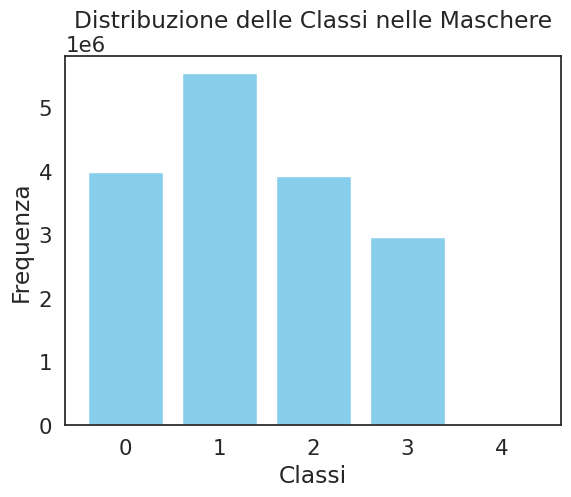

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


It is clear that there are classes that are highly represented, while others are significantly less represented

###preparing the dataset

We prepare the training dataset (applying augmentations such as random flipping, random color augmentations, and random crop and resize), along with the validation and test datasets. Additionally, we set essential parameters such as batch size, patience, number of epochs, and learning rate.

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """
    Random horizontal flip for image and its corresponding segmentation mask (label).
    Displays three images with masks before and after the flip.

    Args:
        image: Tensor representing the image, dimension [H, W, C].
        label: Tensor representing the segmentation mask, dimension [H, W] or [H, W, 1].
        seed: Optional seed for the random generator.

    Returns:
        Flipped (or unchanged) image and label.
    """
    # Generate a random seed if not provided
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure the label has 3 dimensions
    if len(label.shape) == 2:  # Add a channel dimension
        label = tf.expand_dims(label, axis=-1)

    # Save copies of the original images and masks for visualization
    original_image = image.numpy() if tf.executing_eagerly() else image
    original_label = label.numpy() if tf.executing_eagerly() else label

    # Random uniform to determine the flip
    flip_prob = tf.random.uniform([], seed=seed)

    # Apply conditional horizontal flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
   


In [ ]:
import tensorflow as tf
import numpy as np

@tf.function
def random_color_augmentations(image, label, brightness_delta=0.5, contrast_lower=0.5, contrast_upper=0.6, seed=None):
    """
    Applies color augmentations on grayscale image and mask.

    Args:
        image: Image tensor, dimension [H, W, 1].
        label: Segmentation mask tensor, dimension [H, W] or [H, W, 1].
        brightness_delta: Random brightness variation (positive or negative).
        contrast_lower: Lower limit for contrast.
        contrast_upper: Upper limit for contrast.
        seed: Optional seed for randomization.

    Returns:
        image, label: Transformed image and mask.
    """
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Modify brightness
    image = tf.image.random_brightness(image, max_delta=brightness_delta, seed=seed)

    # Modify contrast
    image = tf.image.random_contrast(image, lower=contrast_lower, upper=contrast_upper, seed=seed)

    # Normalize image (optional, if necessary)
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensures values are between 0 and 1

    # Since the mask has no color channels, we do not modify it (optional)
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)  # Add a channel dimension if necessary

    return image, label


In [ ]:
def random_crop_and_resize(image, label, crop_height=58, crop_width=120, target_height=64, target_width=128):
    """
    Applies a random crop to the image and mask to remove side rows,
    then resizes the image and mask to the target dimensions.
    """
    # Ensure that the image and mask have the same shape
    image_shape = tf.shape(image)

    # Calculate the random crop (ensure the final size is valid)
    offset_height = tf.random.uniform([], 0, image_shape[0] - crop_height, dtype=tf.int32)
    offset_width = tf.random.uniform([], 0, image_shape[1] - crop_width, dtype=tf.int32)

    # Apply the crop
    image_cropped = image[offset_height:offset_height + crop_height, offset_width:offset_width + crop_width]
    label_cropped = label[offset_height:offset_height + crop_height, offset_width:offset_width + crop_width]

    # Resize the image and mask to the target dimensions
    image_resized = tf.image.resize(image_cropped, [target_height, target_width])
    label_resized = tf.image.resize(label_cropped, [target_height, target_width], method='nearest')  # Using 'nearest' for the mask

    return image_resized, label_resized


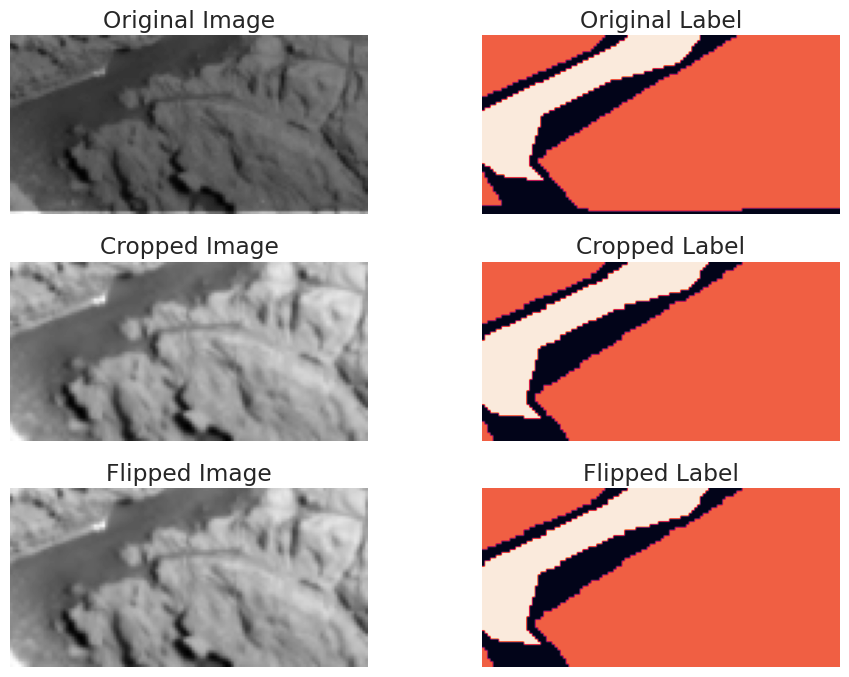

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Take an instance from X_train and y_train
sample_image = X_train[30]  # First image of X_train
sample_label = y_train[30]  # First mask of y_train

# Convert to TensorFlow tensors (if necessary)
sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
sample_label = tf.convert_to_tensor(sample_label, dtype=tf.float32)

# Ensure both have at least 3 dimensions
if len(sample_image.shape) == 2:  # (H, W)
    sample_image = tf.expand_dims(sample_image, axis=-1)  # Add channel dimension

if len(sample_label.shape) == 2:  # (H, W)
    sample_label = tf.expand_dims(sample_label, axis=-1)  # Add channel dimension

# Set crop dimensions (modify as needed)
crop_height = 60
crop_width = 122

# Apply crop
cropped_image, cropped_label = random_crop_and_resize(sample_image, sample_label)

# Apply random_flip function on the instance
aug_image, aug_label = random_flip(cropped_image, cropped_label)

# Visualize the results
def plot_from_array(original_image, original_label, cropped_image, cropped_label, augmented_image, augmented_label):
    """
    Visualize an instance of X_train and y_train before and after augmentation and crop.
    """
    plt.figure(figsize=(10, 7))

    # Visualize the original image
    plt.subplot(3, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image.numpy().squeeze(), cmap='gray')  # Remove unnecessary dimensions
    plt.axis('off')

    plt.subplot(3, 2, 2)
    plt.title("Original Label")
    plt.imshow(original_label.numpy().squeeze())  # Remove unnecessary dimensions
    plt.axis('off')

    # Visualize the image after crop
    plt.subplot(3, 2, 3)
    plt.title("Cropped Image")
    plt.imshow(cropped_image.numpy().squeeze(), cmap='gray')  # Remove unnecessary dimensions
    plt.axis('off')

    plt.subplot(3, 2, 4)
    plt.title("Cropped Label")
    plt.imshow(cropped_label.numpy().squeeze())  # Remove unnecessary dimensions
    plt.axis('off')

    # Visualize the flipped image
    plt.subplot(3, 2, 5)
    plt.title("Flipped Image")
    plt.imshow(augmented_image.numpy().squeeze(), cmap='gray')  # Remove unnecessary dimensions
    plt.axis('off')

    plt.subplot(3, 2, 6)
    plt.title("Flipped Label")
    plt.imshow(augmented_label.numpy().squeeze())  # Remove unnecessary dimensions
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the instance and the result of crop and flip
plot_from_array(sample_image, sample_label, cropped_image, cropped_label, aug_image, aug_label)


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
import numpy as np

# Add the channel to X_train and X_test
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel
X_test_tmp = np.expand_dims(X_test_tmp, axis=-1)  # Add a channel
X_val = np.expand_dims(X_val, axis=-1)

input_shape = X_train.shape[1:]  # The input shape (excluding batch dimension)
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import tensorflow as tf

def make_dataset(X_train, y_train, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from X_train and y_train.

    Parameters:
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of elements per batch.
    - shuffle: If True, shuffle the dataset.
    - augment: If True, apply augmentations to the images.
    - seed: Optional seed for randomness.

    Returns:
    - dataset: TensorFlow dataset.
    """

    # Add the fourth dimension to y_train if necessary
    if len(y_train.shape) == 3:  # If y_train is shaped (n_samples, height, width)
        y_train = tf.expand_dims(y_train, axis=-1)  # Convert to (n_samples, height, width, 1)

    # Create a dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Apply shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size, seed=seed)

    # Apply augmentations
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Perform batching
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Optimize data loading
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test_tmp, y_test_tmp,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


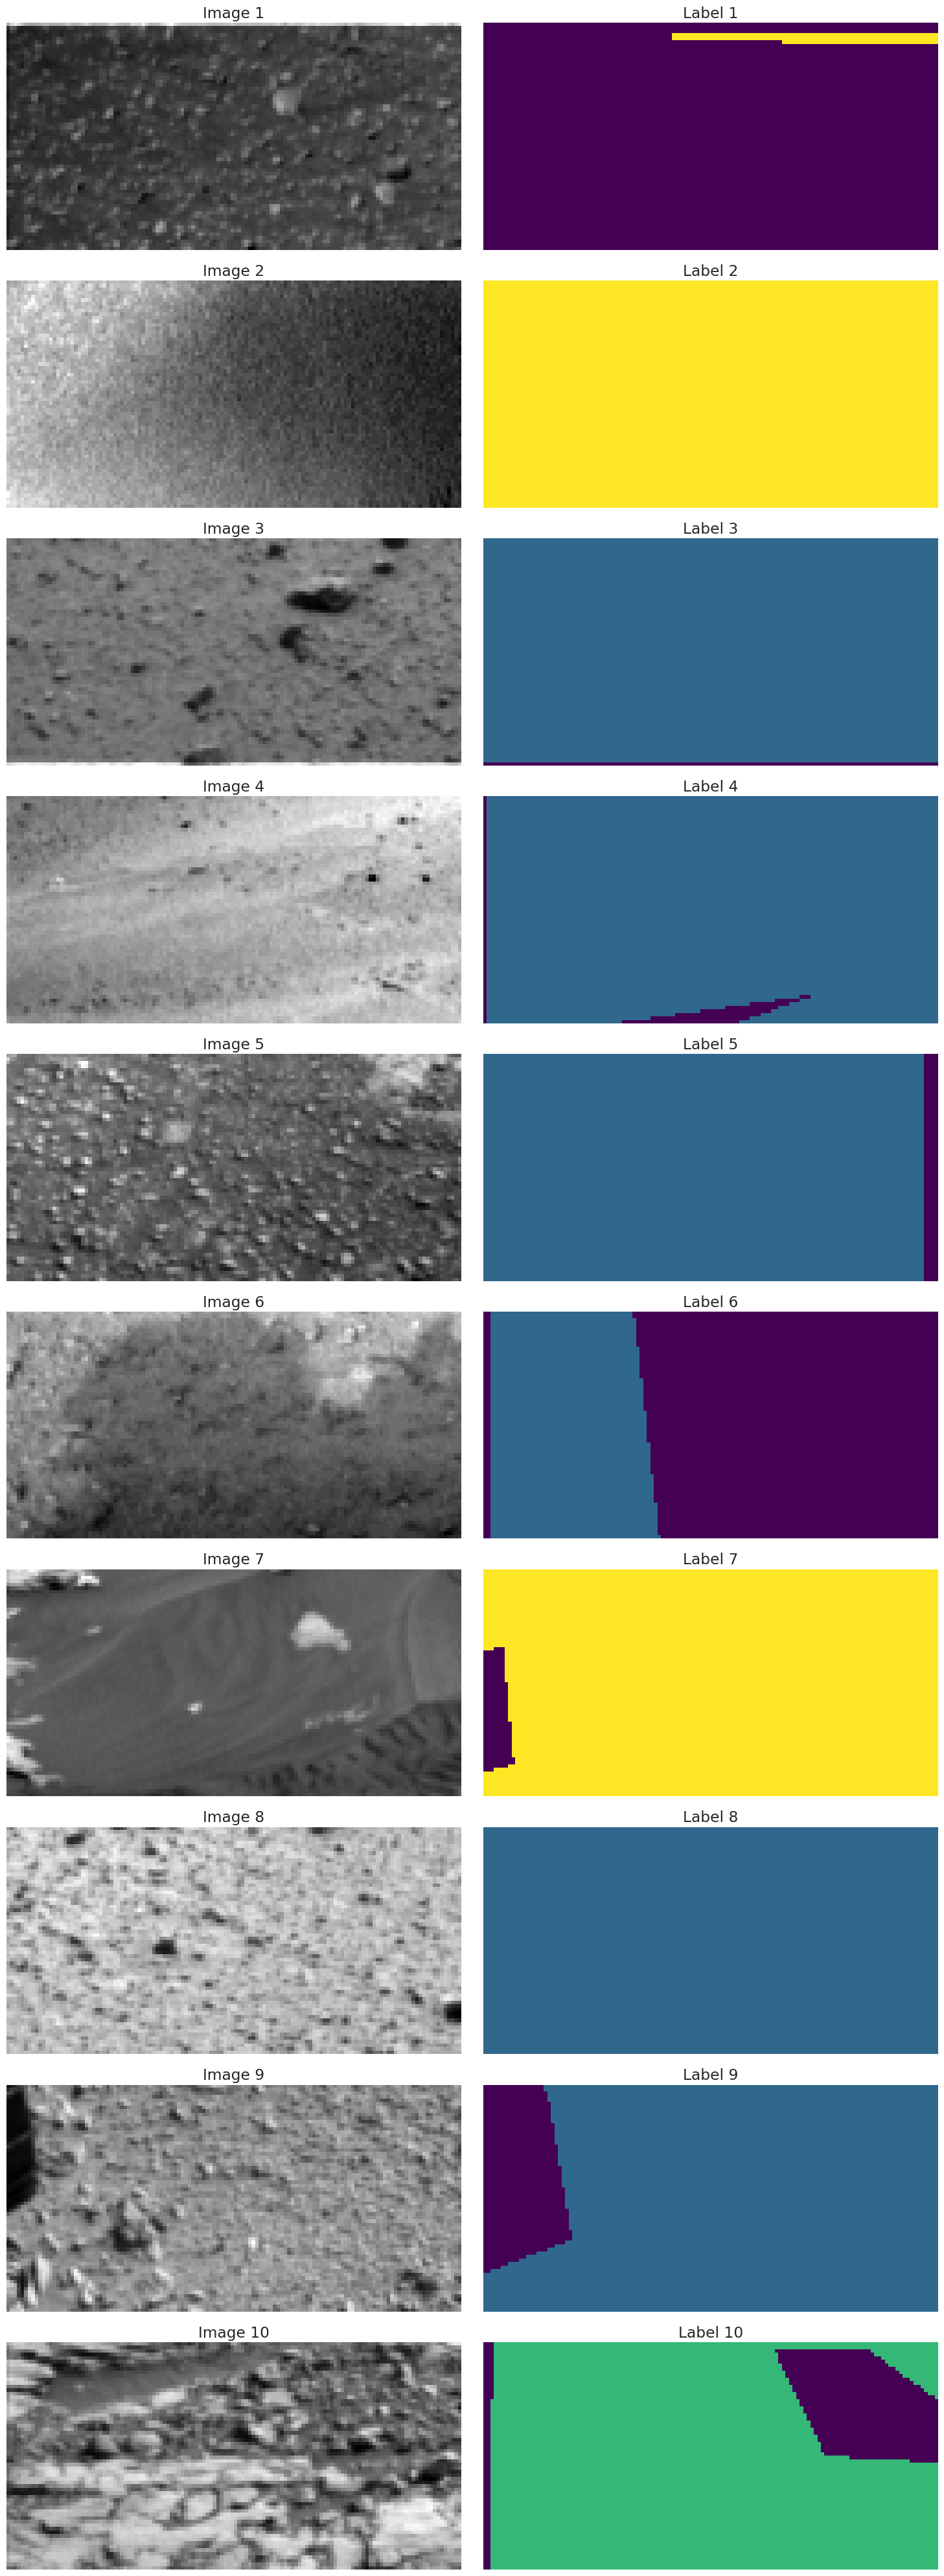

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(tf.squeeze(images[j], axis=-1)*255, cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

Above are examples of the training dataset created

##💡Model

We define a U-Net model with 3 downsampling layers and 3 upsampling layers (using a basic U-block). In the bottleneck, we implement an ASPP layer

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def aspp_block(input_tensor, filters=128, dropout_rate=0.3):
    """Atrous Spatial Pyramid Pooling (ASPP) Block with Dropout"""
    # 1x1 Convolution
    conv_1x1 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(input_tensor)

    # Dilated convolutions
    conv_3x3_1 = tfkl.Conv2D(filters, (3, 3), dilation_rate=6, padding="same", activation="relu")(input_tensor)
    conv_3x3_2 = tfkl.Conv2D(filters, (3, 3), dilation_rate=12, padding="same", activation="relu")(input_tensor)
    conv_3x3_3 = tfkl.Conv2D(filters, (3, 3), dilation_rate=18, padding="same", activation="relu")(input_tensor)

    # Global Average Pooling
    gap = tfkl.GlobalAveragePooling2D()(input_tensor)
    gap = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(gap)
    gap = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(gap)
    gap = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]))(gap)

    # Concatenate all branches
    x = tfkl.Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, gap])
    x = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)

    # Add Spatial Dropout
    x = tfkl.SpatialDropout2D(dropout_rate)(x)

    return x


In [ ]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    """U-Net Model with 3 Downsampling and 3 Upsampling Blocks"""
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with ASPP
    bottleneck = aspp_block(d3, filters=256,dropout_rate=0.3)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Add Spatial Dropout in the Decoder Path
    u3 = tfkl.SpatialDropout2D(rate=0.3)(u3)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 2,344,261 (8.94 MB)

 Trainable params: 2,342,469 (8.94 MB)

 Non-trainable params: 1,792 (7.00 KB)

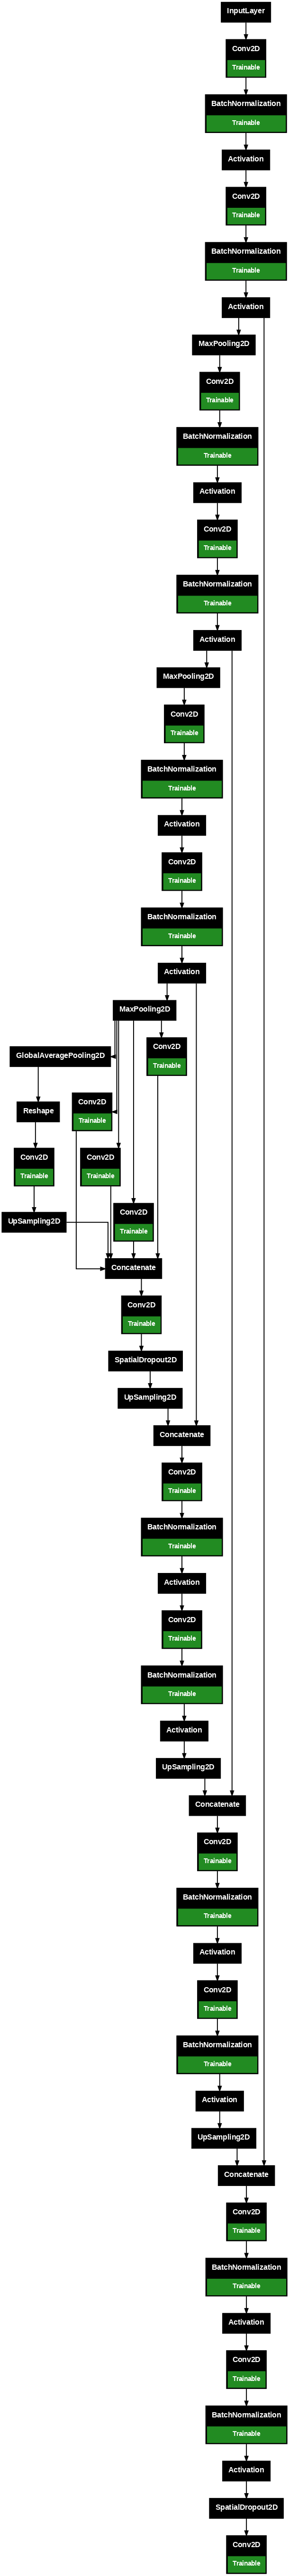

In [ ]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Above, you can see the structure of the created model and the number of parameters

We define the MIoU (Mean Intersection over Union) and the Viz Callback to monitor the model's performance during training. MIoU is used as a metric to evaluate the accuracy of pixel-wise segmentation, while the Viz Callback helps visualize the model's predictions in real-time, providing insights into the training process.

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_images, sample_labels, frequency=5):
        """
        Visualization callback to monitor predictions during training.

        Args:
        - sample_images: A list of two NumPy arrays, each representing an image.
        - sample_labels: A list of two NumPy arrays, each representing a segmentation mask.
        - frequency: Frequency in terms of epochs to visualize the results.
        """
        super().__init__()
        self.sample_images = sample_images  # List of two images
        self.sample_labels = sample_labels  # List of two masks
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        """
        Visualizes predictions at the end of every `frequency` epochs.
        """
        if epoch % self.frequency == 0:
            num_samples = len(self.sample_images)

            # Create the colormap
            num_classes = self.model.output_shape[-1]  # Number of classes from the model
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4 * num_samples))  # Expand vertical size for multiple images

            for i in range(num_samples):
                image = tf.expand_dims(self.sample_images[i], 0)  # Add batch dimension
                label = self.sample_labels[i]  # Associated label

                # Generate prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()[0]  # Remove batch dimension

                # Input image
                plt.subplot(num_samples, 3, i * 3 + 1)
                plt.imshow(tf.squeeze(self.sample_images[i]), cmap='gray')
                plt.title(f"Input Image {i + 1}")
                plt.axis('off')

                # Ground truth
                plt.subplot(num_samples, 3, i * 3 + 2)
                colored_label = apply_colormap(label, colormap)
                plt.imshow(colored_label)
                plt.title(f"Ground Truth Mask {i + 1}")
                plt.axis('off')

                # Prediction
                plt.subplot(num_samples, 3, i * 3 + 3)
                colored_pred = apply_colormap(y_pred, colormap)
                plt.imshow(colored_pred)
                plt.title(f"Predicted Mask {i + 1}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


sample_images = [X_val[0], X_val[1]]
sample_labels = [y_val[0], y_val[1]]
viz_callback = VizCallback(sample_images, sample_labels, frequency=5)


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)


We compute class weights to address class imbalance and normalize them into alpha. This alpha is then used in the custom Sparse Categorical Focal Loss function, which emphasizes harder examples during training. The custom loss function adjusts the impact of each class and focuses on improving model performance on difficult-to-classify samples

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np  # Import numpy

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2, 3, 4]),  # Convert the list to a NumPy array
    y=y_train.flatten(),  # y_train must be in 1D format
)
alpha = class_weights / sum(class_weights)
print(alpha)


[0.00524455 0.00377298 0.00531845 0.00705449 0.97860952]


In [ ]:
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, name="sparse_categorical_focal_loss"):
        """
        Implements Focal Loss for integer labels.

        Parameters:
        - gamma: Modulates the balance between easy and difficult examples.
        - alpha: Balances the contribution of classes (e.g., for class imbalance).
        """
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha  # Store alpha as an attribute, but don't calculate it here

    def call(self, y_true, y_pred):
        # Calculate alpha inside the call method if it's not provided
        if self.alpha is None:
            classes, counts = np.unique(y_train, return_counts=True)
            class_weights = compute_class_weight(
                class_weight="balanced",
                classes=np.array([0, 1, 2, 3, 4]),
                y=y_train.flatten()
            )
            alpha = class_weights / sum(class_weights)
        else:
            alpha = self.alpha  # Use the provided alpha if available

        alpha = tf.cast(alpha, tf.float32)  # Cast alpha to tf.float32

        # Convert predicted probabilities to log probabilities
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)

        # Calculate the probability of the true class
        one_hot_y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
        true_prob = tf.reduce_sum(y_pred * one_hot_y_true, axis=-1)

        # Apply Focal Loss
        weight = tf.pow(1.0 - true_prob, self.gamma)  # Focus on hard examples

        # Reshape alpha to match the shape of weight
        alpha_reshaped = tf.gather(alpha, tf.cast(y_true[..., 0], tf.int32))  # Gather alpha values for true classes

        focal_loss = -alpha_reshaped * weight * tf.math.log(true_prob)

        return tf.reduce_mean(focal_loss)

    # Updated get_config method
    def get_config(self):
        """
        Returns the configuration of the loss function.
        """
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha.tolist() if self.alpha is not None else None  # Ensure serializable type
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a loss instance from the configuration.
        """
        return cls(**config)


In [ ]:
# Compile the model

print("Compiling model...")
model.compile(
    loss=SparseCategoricalFocalLoss,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


###training

We can train the model, using early stopping to prevent overfitting and reduce computational time, along with a learning rate reduction when the loss plateaus

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Configure ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='loss',        # The metric to monitor, usually 'loss' or 'val_loss'
    factor=0.5,            # Reduction factor (e.g., reduce the learning rate by half)
    patience=10,           # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6,           # Minimum learning rate
    verbose=1              # Show a message when the learning rate is reduced
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
#model.save(model_filename)

# Delete the model to free up resources
#del model


In [ ]:
weights_filename = 'UNet_weights_' + str(final_val_meanIoU) + '.weights.h5'
model.save_weights(weights_filename)

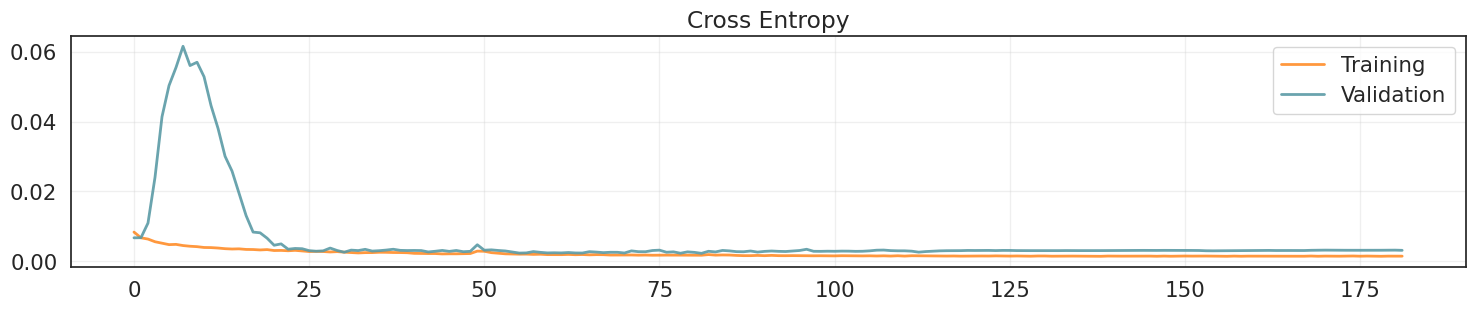

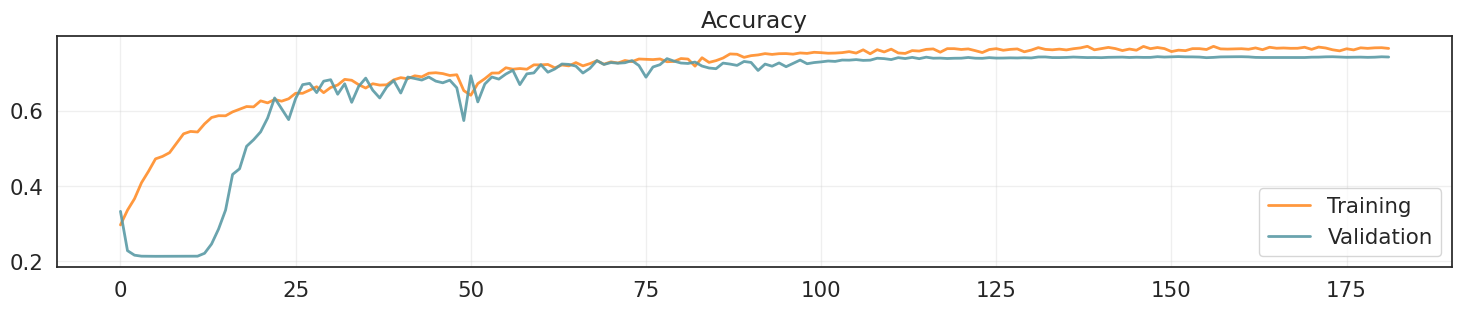

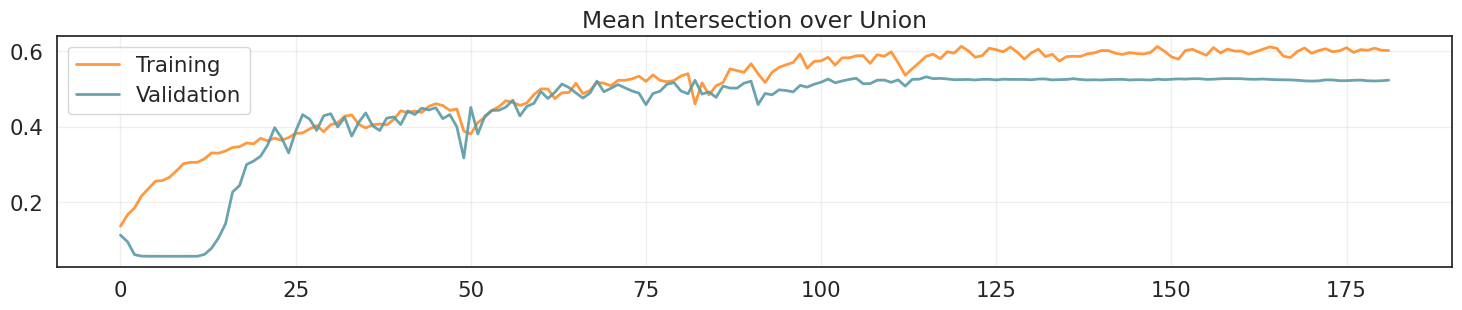

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Above, you can see the progress of the Loss function and of the accuracy and miou for both Training and Validation during the model training

###make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_3        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d_3[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 2,344,261 (8.94 MB)

 Trainable params: 2,342,469 (8.94 MB)

 Non-trainable params: 1,792 (7.00 KB)

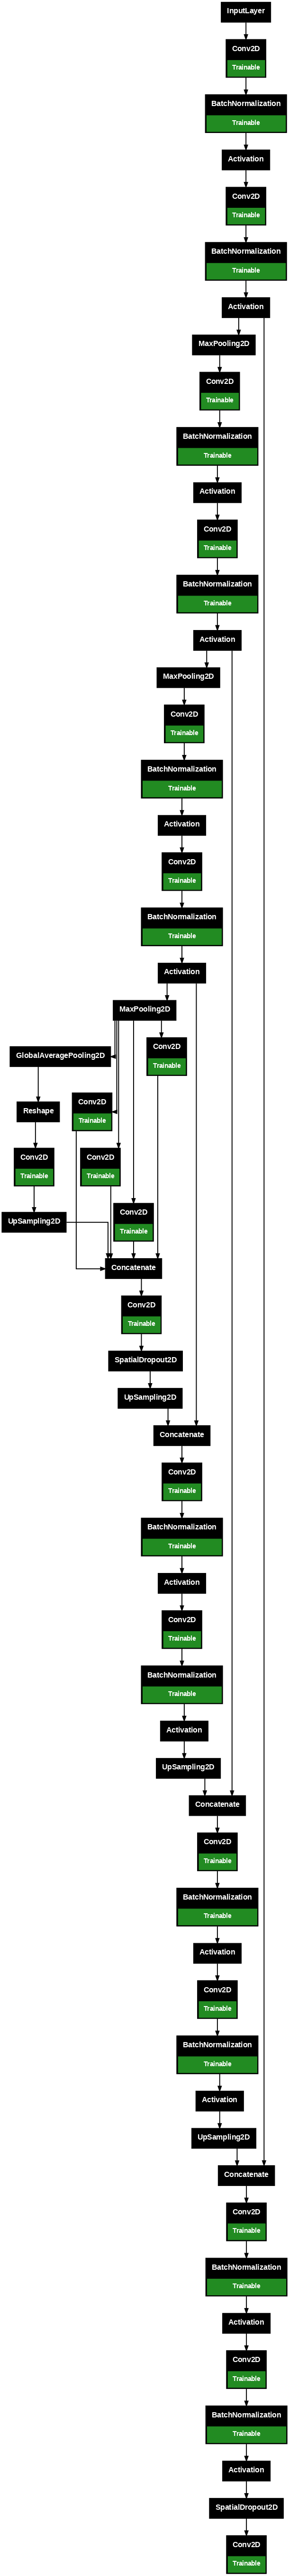

In [ ]:
# Create the model with the same architecture
model = get_unet_model(input_shape=(64, 128, 1), num_classes=5)

# Load the weights
model.load_weights(weights_filename)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.7632
Test Mean Intersection over Union: 0.517


Above, we can see the results from the predictions made on the test dataset

Below, we process the test dataset, generating predictions using the trained model. Random samples are visualized, displaying the original image, the true mask, and the predicted mask to evaluate the model's performance

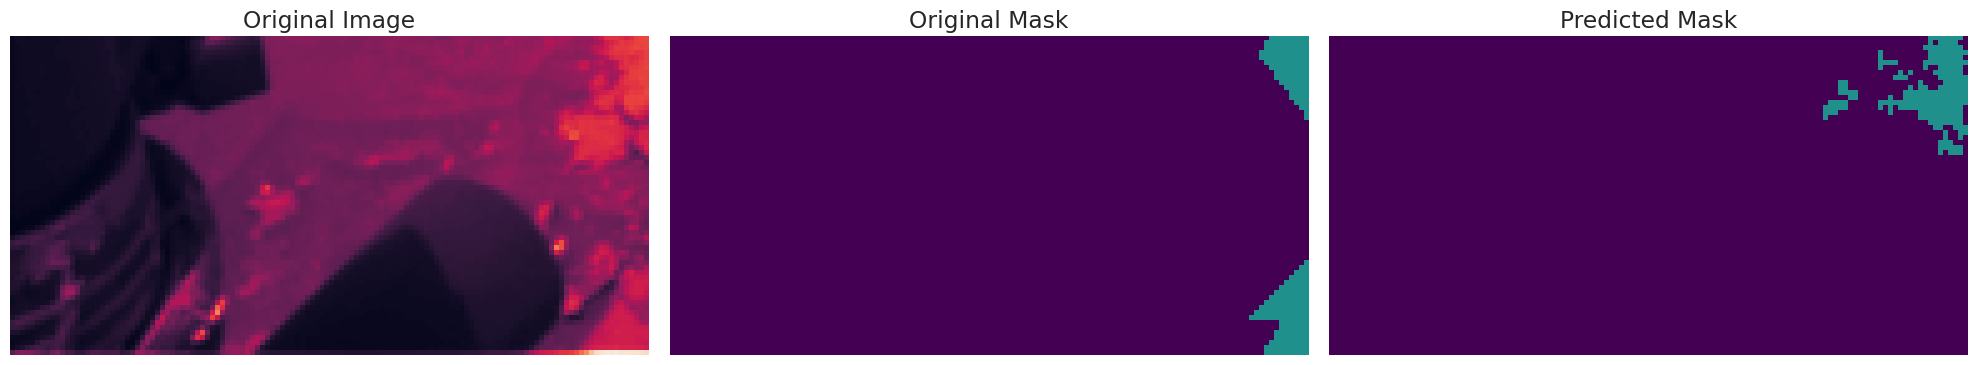

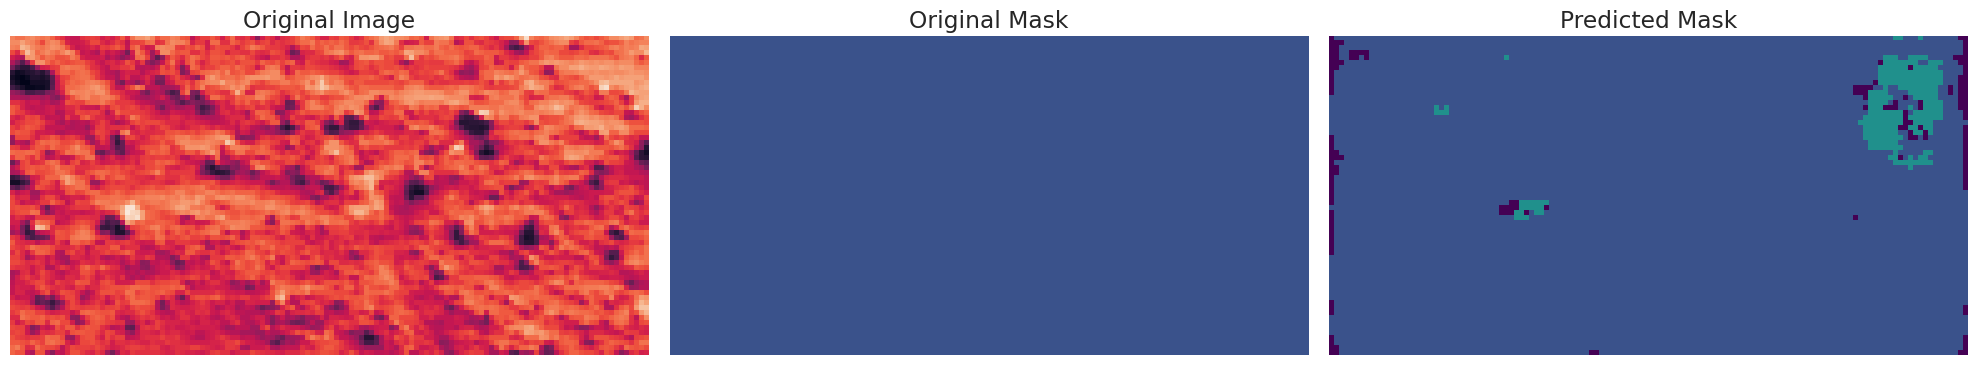

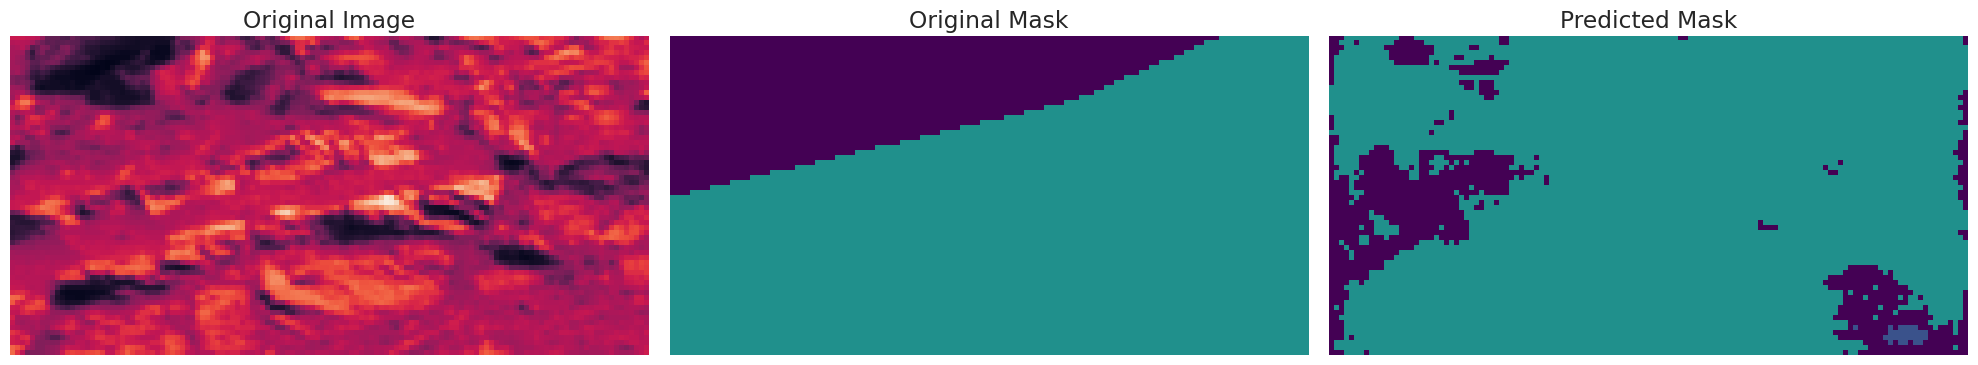

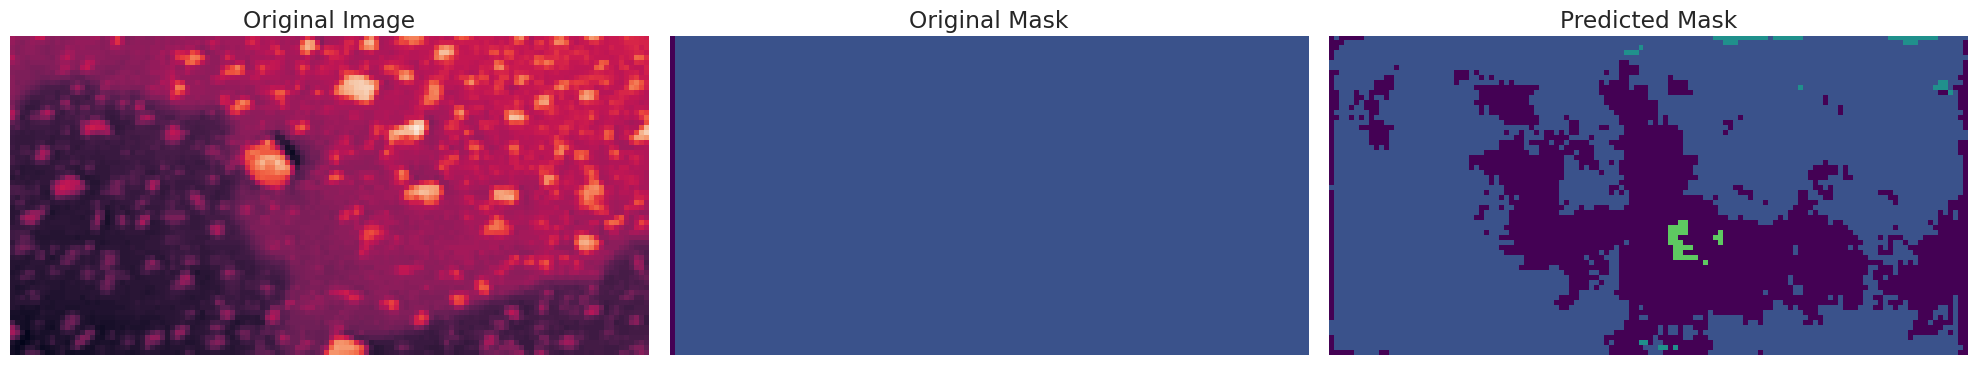

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        num_classes = 5 #ATTENTION ! Modification did here in place of the following 2 lines. TODO: double check
        # labels_np = labels.numpy()
        # num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0])
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        colored_label = apply_colormap(labels[0], colormap)
        axes[1].imshow(colored_label)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        colored_pred = apply_colormap(pred[0], colormap)
        axes[2].imshow(colored_pred)
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=7)

In [ ]:
data = np.load("filtered_mars_for_students.npz")
X_test = data["test_set"]
X_test = X_test / 255.0
X_test = np.expand_dims(X_test, axis=-1)  # Add a channel
print(f"X_test shape: {X_test.shape}")

# Predict in batches to avoid OOM errors
batch_size = 32  # Adjust batch size as needed based on your GPU memory
num_samples = X_test.shape[0]
preds = []

for i in range(0, num_samples, batch_size):
    batch_preds = model.predict(X_test[i:i + batch_size], verbose=0)
    preds.extend(np.argmax(batch_preds, axis=-1))

preds = np.array(preds)  # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")


X_test shape: (10022, 64, 128, 1)
Predictions shape: (10022, 64, 128)


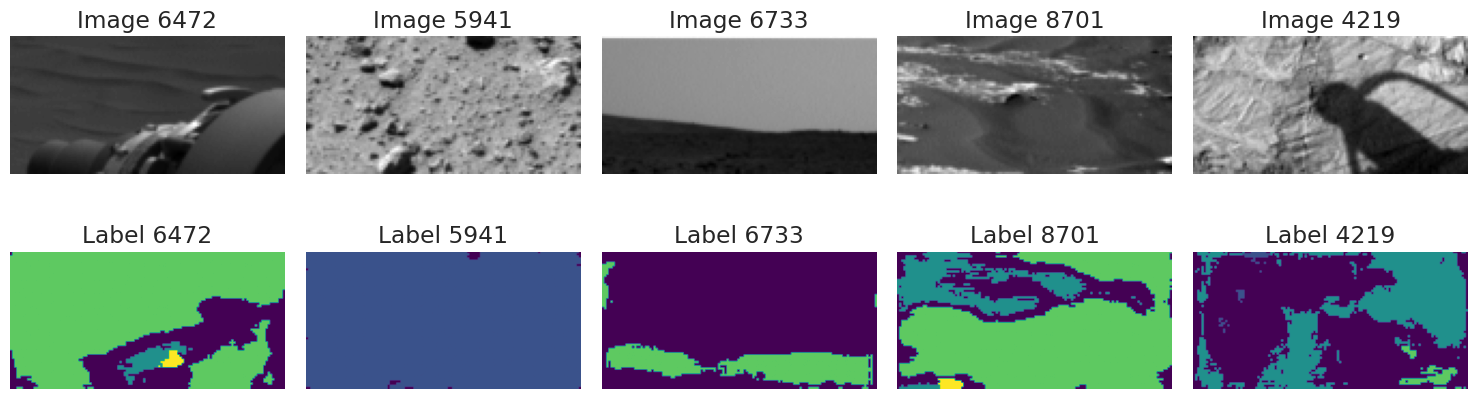

In [ ]:
# Plot 5 random images with labels
plot_random_images_with_labels(X_test, preds, num=5)


Distribuzione delle classi: {0: 19374146, 1: 25205032, 2: 22634360, 3: 14662497, 4: 224189}


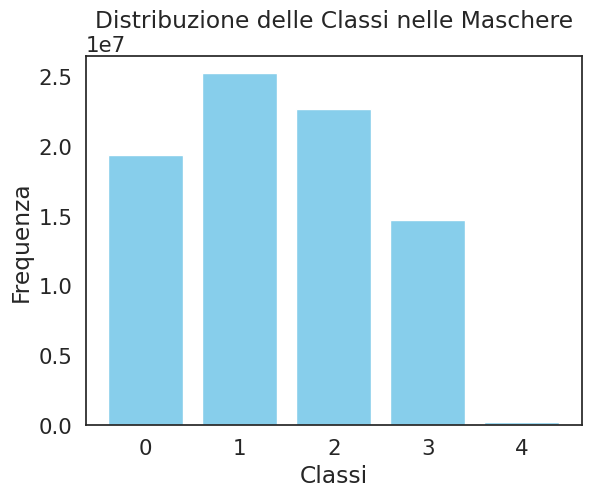

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute class frequencies
unique, counts = np.unique(preds, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar chart
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


Above, we calculate and visualize the distribution of predicted classes, providing insights into class frequencies, and print the number of unique predicted classes to assess the model's output diversity

##🗂️preparing the submission

In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved to: {submission_filename}")
# from google.colab import files
# files.download(submission_filename)

Submission file saved to: submission_UNet_53.26.csv
